<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/eda_nytimes-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining NYTimes data with county census and geoson data

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly      # linear regression
import pandas as pd

from scipy.signal import savgol_filter          # fast smoothing of data

# opening external coordinates
import json
import pickle

# opening urls
from urllib.request import urlopen

# benchmarking
from time import time

# date/time operations
from datetime import datetime, timedelta
from pytz import timezone

import json

# plotting
import matplotlib.pyplot as plt

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [2]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col:
        pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
            
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    
    return dft

In [3]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df_raw = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df_raw.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [4]:
nyt_df_raw['fips'] = nyt_df_raw['fips'].astype('object')
nyt_df_raw.loc[nyt_df_raw['county'] == 'New York City','fips'] = '36NYC'
nyt_df_raw.loc[nyt_df_raw['county'] == 'Kansas City','fips'] = '29KCM'
nyt_df_raw.loc[nyt_df_raw['county'] == 'Joplin','fips'] = '29JOP'
nyt_df_raw['fips'] = nyt_df_raw['fips'].astype('category')

In [5]:
nyt_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518297 entries, 0 to 518296
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    518297 non-null  datetime64[ns]
 1   county  518297 non-null  category      
 2   state   518297 non-null  category      
 3   fips    513754 non-null  category      
 4   cases   518297 non-null  int32         
 5   deaths  518297 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 9.7 MB


# import `info_df`

In [6]:
with open('../data/processed/info_df.p', 'rb') as f:
    info_df = pickle.load(f)
print(info_df.shape)
info_df.head()

(3140, 231)


,state_fips,state,county,fips,tot_pop,tot_male,tot_female,tot_pop_white_male,tot_pop_white_female,tot_pop_black_male,...,per_pop_hispanic_male,per_pop_hispanic_female,per_pop_white,per_pop_black,per_pop_native,per_pop_asian,per_pop_pacific,per_pop_twoplus,per_pop_hispanic,per_votes
0,01,Alabama,Autauga,01001,55869,27092.0,28777.0,20138.0,21077.0,5171.0,...,0.015823,0.014087,0.737708,0.198643,0.004349,0.011563,0.000716,0.017111,0.029909,0.441408
1,01,Alabama,Baldwin,01003,223234,108247.0,114987.0,89845.0,95902.0,9308.0,...,0.024839,0.022349,0.832073,0.086076,0.006751,0.010509,0.000551,0.016852,0.047188,0.421486
2,01,Alabama,Barbour,01005,24686,13064.0,11622.0,5894.0,5341.0,6260.0,...,0.025480,0.019768,0.455116,0.478287,0.003848,0.004699,0.001256,0.011545,0.045248,0.420886
3,01,Alabama,Bibb,01007,22394,11929.0,10465.0,8482.0,8181.0,2912.0,...,0.015317,0.012503,0.744083,0.210726,0.004064,0.002054,0.000268,0.010985,0.027820,0.390640
4,01,Alabama,Blount,01009,57826,28472.0,29354.0,24494.0,25682.0,453.0,...,0.051015,0.045516,0.867707,0.015080,0.004877,0.002819,0.000363,0.012624,0.096531,0.438972


In [7]:
with open('../data/processed/geo_json.json') as f:
    geo_json = json.load(f)

## engineer per capita columns

In [8]:
nyt_df = nyt_df_raw.merge(
    info_df[['fips', 'tot_pop']], 
    on='fips', 
    suffixes=('_x','')
)

# df_all = df_all.drop(['county_x', 'state_x'], axis=1)
nyt_df[['cases_per_100k', 'deaths_per_100k']] = nyt_df[['cases', 'deaths']].div(nyt_df['tot_pop'], axis=0) * 100_000
nyt_df = nyt_df.drop(columns=['tot_pop'])
nyt_df = nyt_df.sort_values(by=['date', 'fips'])

print(nyt_df.shape)
nyt_df.head()

(503046, 8)


,date,county,state,fips,cases,deaths,cases_per_100k,deaths_per_100k
0,2020-01-21,Snohomish,Washington,53061,1,0,0.121642,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0,0.121642,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0,0.121642,0.0
233,2020-01-24,Cook,Illinois,17031,1,0,0.019417,0.0
3,2020-01-24,Snohomish,Washington,53061,1,0,0.121642,0.0


In [26]:
nyt_df_w = nyt_df[((datetime(2020, 9, 9) - nyt_df['date']) / timedelta(days=1)) % 7 == 0]

nyt_df_w.head()

,date,county,state,fips,cases,deaths,cases_per_100k,deaths_per_100k
1,2020-01-22,Snohomish,Washington,53061,1,0,0.121642,0.0
695,2020-01-29,Maricopa,Arizona,04013,1,0,0.022294,0.0
923,2020-01-29,Los Angeles,California,06037,1,0,0.009961,0.0
467,2020-01-29,Orange,California,06059,1,0,0.031489,0.0
238,2020-01-29,Cook,Illinois,17031,1,0,0.019417,0.0


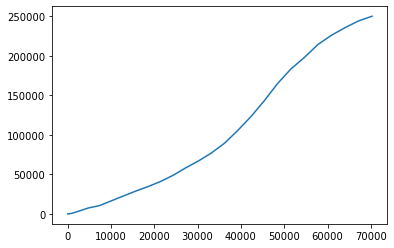

In [14]:
nyt_df_w[nyt_df_w['county']=='Los Angeles']['cases'].plot()

## engineer change columns, window sum, and smooth

In [27]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=False):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    df[new_cols] = df[new_cols].astype(int)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_window_cols(df, cols, window=7):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [c + '_' + str(window) + 'd' for c in cols]
    col_dict = dict(zip(cols, new_cols))
    df = (df.merge(df.sort_values(by=['date', 'fips'])
            .groupby('fips')
            .rolling(15, on='date', min_periods=0)[cols].sum()
            .rename(columns=col_dict), on=['fips', 'date']))
#     df[new_cols] = df[new_cols].astype(int)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7, clip=False):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [c + '_' + str(window) + 'sg' for c in cols]
    df[new_cols] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_cols(df, cols, window, sg=True):
    df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
    df, cols_15d = add_window_cols(df, new_cols, window)
    if sg:
        df, new_cols_15sg = add_savgol_cols(df, new_cols, window, clip=True)
    df, delta_new_cols = add_change_cols(df, new_cols, pre='delta_')
    df, delta_cols_15d = add_window_cols(df, delta_new_cols, window)
    if sg:
        df, delta_new_cols_15sg = add_savgol_cols(df, delta_new_cols, window)

    df['days'] = ((df['date'] - df['date'].max()) / np.timedelta64(1, 'D')).astype('int')
    df['mortality_rate'] = df['deaths'] / nyt_df['cases']
    df[f'mortality_rate_{window}d'] = df[f'new_deaths_{window}d'] / df[f'new_cases_{window}d']
    df.loc[(df[f'new_deaths_{window}d'] ==0), f'mortality_rate_{window}d'] = 0

    return df

In [28]:
nyt_df_w = add_cols(nyt_df_w, cols, 2, sg=False)
nyt_df_w.head()

,date,county,state,fips,cases,deaths,cases_per_100k,deaths_per_100k,new_cases,new_deaths,...,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_2d,delta_new_deaths_2d,delta_new_cases_per_100k_2d,delta_new_deaths_per_100k_2d,days,mortality_rate,mortality_rate_2d
0,2020-01-22,Snohomish,Washington,53061,1,0,0.121642,0.0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,-231,0.0,0.0
1,2020-01-29,Maricopa,Arizona,04013,1,0,0.022294,0.0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,-224,0.0,0.0
2,2020-01-29,Los Angeles,California,06037,1,0,0.009961,0.0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,-224,0.0,0.0
3,2020-01-29,Orange,California,06059,1,0,0.031489,0.0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,-224,0.0,0.0
4,2020-01-29,Cook,Illinois,17031,1,0,0.019417,0.0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,-224,0.0,0.0


Incidentally, there is barely any time advantage to only processing new dates. Therefore, we'll keep the workflow to processing the entire dataframe.

In [ ]:
print(nyt_df.columns)
nyt_df.head()

In [ ]:
nyt_df['days'] = ((nyt_df['date'] - nyt_df['date'].min()) / np.timedelta64(1, 'D')).astype('int')
nyt_df['mortality_rate'] = nyt_df['deaths'] / nyt_df['cases']
nyt_df['mortality_rate_15d'] = nyt_df['new_deaths_15d'] / nyt_df['new_cases_15d']

In [ ]:
nyt_df['mortality_rate_15d'].describe()

In [ ]:
nyt_df.loc[(nyt_df['mortality_rate_15d'] > 1), 'mortality_rate_15d'] = 1

In [ ]:
nyt_df['mortality_rate_15d'].describe()

In [ ]:
with open('../data/processed/nyt_df.p', 'wb') as file:
    pickle.dump(nyt_df, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
nyt_df_w = nyt_df[((datetime(2020, 9, 9) - nyt_df['date']) / timedelta(days=1)) % 7 == 0].drop([c for c in nyt_df.columns if 'delta' in c], axis=1)

nyt_df_w.head()

In [29]:
nyt_df_w.to_csv('../data/processed/nyt_df_w.csv', index=False)

In [ ]:
nyt_df[['date', 'county', 'state', 'fips', 'cases_per_100k']].info()

# making clustered `nyt_df_ac`

In [ ]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [ ]:
with open('../data/processed/geo_json_ac.json') as f:
    geo_json_ac = json.load(f)

In [ ]:
dem_df_ac = optimize(pd.read_csv('../data/processed/dem_df_ac.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(dem_df_ac.shape)
dem_df_ac.head()

In [ ]:
dem_df_ac.sort_values(by='total_pop').iloc[[0, -1]]

In [ ]:
dem_df_ac.sort_values(by='pop_density').iloc[[0, -1]]

There are several things to consider:

- Raw numbers will show New York City and Los Angeles County with the highest numbers, all other factors being equal.
- Reporting cases as a percentage (or as we'll use later, a per 100k) would better reflect the severity of infections.
- However, a higher population density would likely make it easier to transmit the disease to another person. Looking at the day-to-day change in new cases could allow us to see how quickly the disease is spreading.

The NYTimes dataset deals with New York City, Kansas City, and Joplin as their own entities. As such, they do not have valid `fips` codes; we must add our custom `fips` from our earlier census EDA.

In [ ]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = '36NYC'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = '29KCM'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = '29JOP'
nyt_df['fips'] = nyt_df['fips'].astype('category')

In [ ]:
nyt_df[nyt_df['fips']=='36NYC']

# merge `nyt_df` and `pop_df` for feature engineering

In [ ]:
dem_df_to_merge = optimize(pd.read_csv('../data/processed/dem_df_to_merge.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(dem_df_to_merge.shape)
dem_df_to_merge.head()

To reduce the size of the resulting `csv`, we will only merge with the `tot_pop` column to engineer our per capita columns. We can merge with `pop_df` again when plotting our data.

In [ ]:
df = nyt_df.merge(
    dem_df_to_merge[['fips', 'cluster', 'state', 'county']], 
    on='fips', 
    suffixes=('_x','')
)

df = df.drop(['county_x', 'state_x'], axis=1)
df = df.sort_values(by=['date', 'fips'])
print(df.shape)
df.head()

In [ ]:
df_clustered = df.groupby(by=['state', 'cluster', 'date']).agg(
    cases=('cases', sum),
    deaths=('deaths', sum)
).dropna().reset_index().astype({'cases': 'int', 'deaths':'int'})

df_clustered.head()

In [ ]:
df = df_clustered.merge(dem_df_ac, on=['state', 'cluster'], suffixes=('_x',''))
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['total_pop'], axis=0) * 100_000
df = df.sort_values(by=['date', 'fips'])

print(df.shape)
df.head()

In [ ]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=False):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7, clip=False):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    if clip:
        df[cols_d] = df[cols_d].clip(lower=0)
    return (df, cols_d)

df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
df, new_cols_7sg = add_savgol_cols(df, new_cols, clip=True)
df, new_cols_15sg = add_savgol_cols(df, new_cols, window=15, clip=True)
df, delta_new_cols = add_change_cols(df, new_cols, pre='delta_')
df, delta_new_cols_7sg = add_savgol_cols(df, delta_new_cols)
df, delta_new_cols_15sg = add_savgol_cols(df, delta_new_cols, window=15)

print(df.columns)
df.head()

In [ ]:
county = 'Los Angeles'
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k', data=df[df['county'] == county], color='gray')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_7sg', data=df[df['county'] == county], color='red')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_15sg', data=df[df['county'] == county], color='blue')

In [ ]:
county = 'New York City'
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k', data=df[df['county'] == county], color='gray')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_7sg', data=df[df['county'] == county], color='red')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_15sg', data=df[df['county'] == county], color='blue')